# 1. 이해하기

## 1.1 전체 흐름

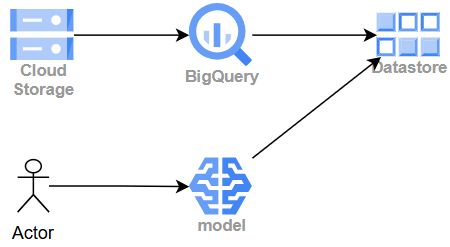

## 1.2 Bigquery table 생성 및 변환

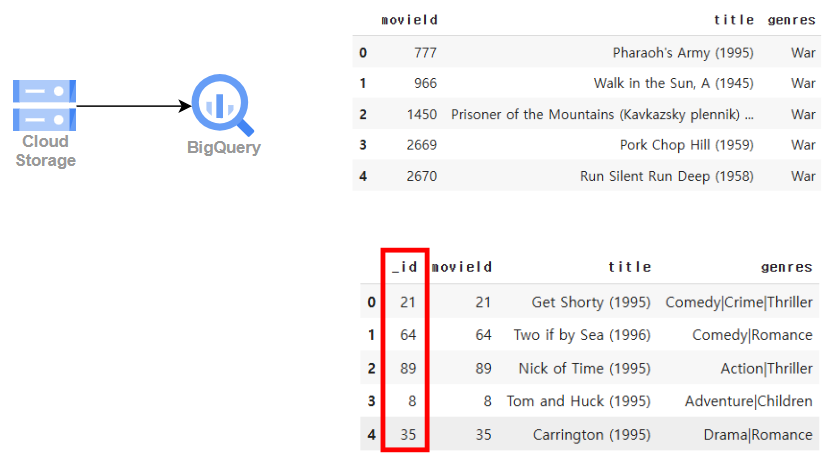

## 1.3 import bigquery in datastore

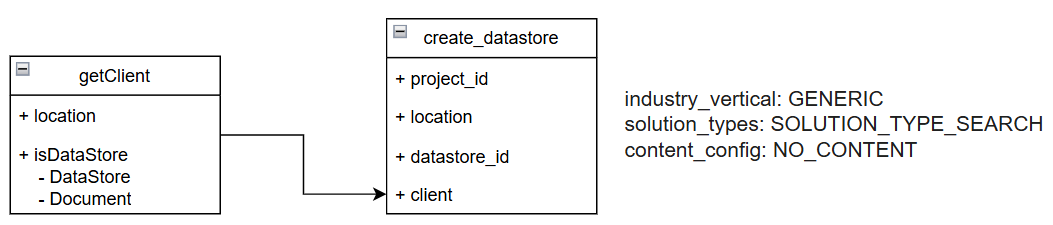

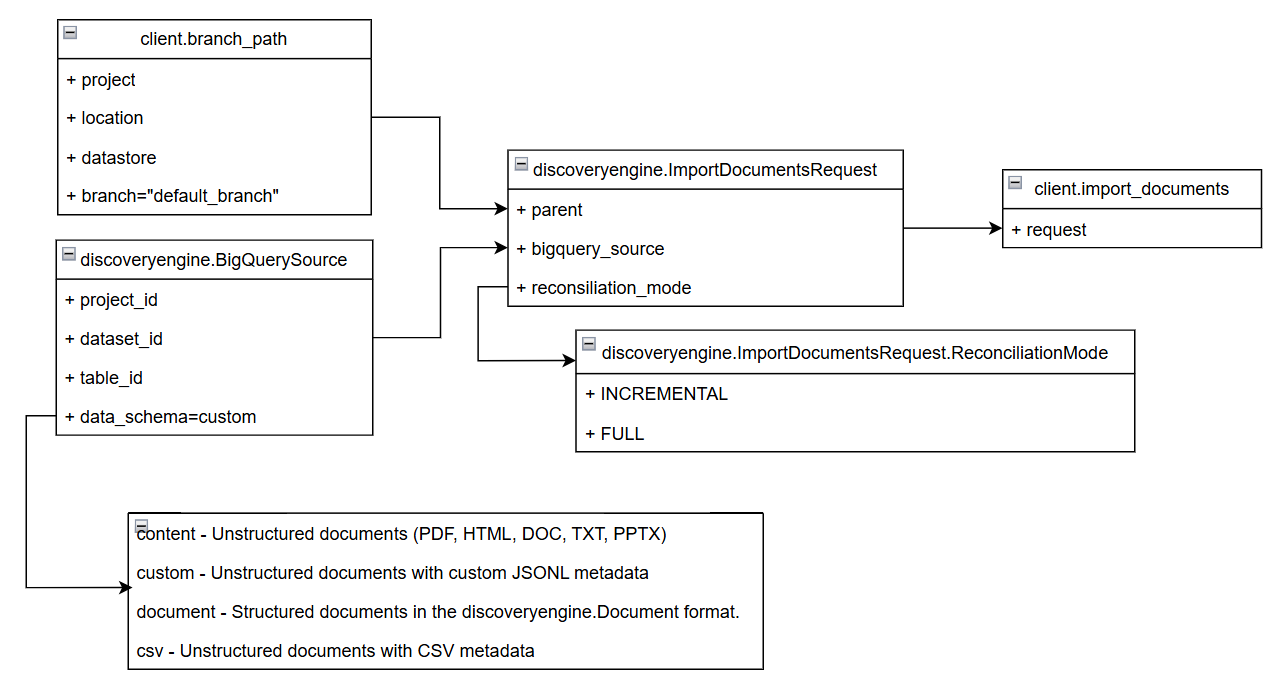

# 2. 코드 이해하기

## 2.1 기본 환경 설정

### 2.1.1 라이브러리 설치

In [6]:
!pip install google-cloud-discoveryengine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.3 MB/s eta 0:00:00


In [7]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 2.1.2 환경변수 설정

In [28]:
PROJECT_ID = !gcloud config get-value project
PROJECT_ID=PROJECT_ID[0]
LOCATION="global"
DATASTORE_ID="bigquery_data_store2"

## 2.2 bigquery

### 2.2.1 data upload

In [ ]:
!bq --location=US mk --dataset movies

Dataset 'younkicho-364103:movies' successfully created.


In [ ]:
!bq load --source_format=CSV --location=us --autodetect movies.movielens_movies_raw gs://dataeng-movielens/movies.csv

Waiting on bqjob_r7ce97760b75da36a_0000019462c40369_1 ... (4s) Current status: DONE   


### 2.2.2 결과 확인

In [3]:
from google.cloud import bigquery

client = bigquery.Client()

In [ ]:
sql = """
SELECT
  *
FROM
  movies.movielens_movies_raw
LIMIT 10
"""

In [ ]:
# Run a Standard SQL query using the environment's default project
# df = client.query(sql).to_dataframe()

# Run a Standard SQL query with the project set explicitly
df = client.query(sql, project=PROJECT_ID).to_dataframe()

df.head()

,movieId,title,genres
0,777,Pharaoh's Army (1995),War
1,966,"Walk in the Sun, A (1945)",War
2,1450,Prisoner of the Mountains (Kavkazsky plennik) ...,War
3,2669,Pork Chop Hill (1959),War
4,2670,Run Silent Run Deep (1958),War


### 2.2.3 신규 table 생성

In [ ]:
# datastore에 저장할 경우 _id가 필요함.
!bq query \
    --destination_table movies.new_movielens_movies_raw \
    --replace \
    --use_legacy_sql=false \
'SELECT ROW_NUMBER() OVER (ORDER BY movieId) AS _id, * ' \
'FROM `younkicho-364103`.`movies`.`movielens_movies_raw` limit 100;'

Waiting on bqjob_r558a712c839adbaa_0000019462e2eb4c_1 ... (1s) Current status: DONE   
+-----+---------+---------------------------------------------------------------------------------+---------------------------------------------+
| _id | movieId |                                      title                                      |                   genres                    |
+-----+---------+---------------------------------------------------------------------------------+---------------------------------------------+
|  34 |      34 | Babe (1995)                                                                     | Children|Drama                              |
|  67 |      67 | Two Bits (1995)                                                                 | Drama                                       |
| 100 |     101 | Bottle Rocket (1996)                                                            | Adventure|Comedy|Crime|Romance              |
|  12 |      12 | Dracula: Dead and L

In [1]:
sql = """
SELECT
  *
FROM
  movies.new_movielens_movies_raw
LIMIT 10
"""

In [5]:
df = client.query(sql, project=PROJECT_ID).to_dataframe()

df.head()

,_id,movieId,title,genres
0,21,21,Get Shorty (1995),Comedy|Crime|Thriller
1,64,64,Two if by Sea (1996),Comedy|Romance
2,89,89,Nick of Time (1995),Action|Thriller
3,8,8,Tom and Huck (1995),Adventure|Children
4,35,35,Carrington (1995),Drama|Romance


## 2.3 datastore

### 2.3.1 DataStore 만들기

In [29]:
from google.api_core.client_options import ClientOptions
from google.cloud import discoveryengine

In [30]:
def getClient(location, isDataStore: bool):
  client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )
  if isDataStore:
    return discoveryengine.DataStoreServiceClient(client_options=client_options)
  return discoveryengine.DocumentServiceClient(client_options=client_options)

In [31]:
def create_datastore(project_id, location, datastore_id, client):
    parent = client.collection_path(
        project_id,
        location,
        collection="default_collection")

    # bigquery에서 data를 읽어 들일 경우 data-store는 NO_CONTENT여야 한다.
    data_store = discoveryengine.DataStore(
        display_name=datastore_id,
        industry_vertical=discoveryengine.IndustryVertical.GENERIC,
        solution_types=[discoveryengine.SolutionType.SOLUTION_TYPE_SEARCH],
        content_config=discoveryengine.DataStore.ContentConfig.NO_CONTENT
    )

    request = discoveryengine.CreateDataStoreRequest(
        parent=parent,
        data_store=data_store,
        data_store_id = DATASTORE_ID
    )

    return client.create_data_store(request=request)

In [32]:
DATASTORE=True
client = getClient(LOCATION, DATASTORE)
operation = create_datastore(PROJECT_ID, LOCATION, DATASTORE_ID, client)
print(operation.result())

name: "projects/429718924597/locations/global/collections/default_collection/dataStores/bigquery_data_store2"
display_name: "bigquery_data_store2"
industry_vertical: GENERIC
solution_types: SOLUTION_TYPE_SEARCH
default_schema_id: "default_schema"
content_config: CONTENT_REQUIRED
document_processing_config {
  name: "projects/429718924597/locations/global/collections/default_collection/dataStores/bigquery_data_store2/documentProcessingConfig"
  default_parsing_config {
    digital_parsing_config {
    }
  }
}
serving_config_data_store {
}



### 2.3.2 bigquery에서 data 가져오기

In [33]:
def importData(project_id, location, datastore_id, client, bigquery_dataset, bigquery_table):
  parent = client.branch_path(
    project= project_id,
    location=location,
    data_store=datastore_id,
    branch="default_branch"
  )

  bigquerySource = discoveryengine.BigQuerySource(
      project_id=project_id,
      dataset_id=bigquery_dataset,
      table_id=bigquery_table,
      data_schema="custom"
  )
  request = discoveryengine.ImportDocumentsRequest(
      parent=parent,
      bigquery_source=bigquerySource,
      reconciliation_mode = discoveryengine.ImportDocumentsRequest.ReconciliationMode.INCREMENTAL
  )

  return client.import_documents(request=request)

In [34]:
DOCUMENTSERVICE=False
client = getClient(LOCATION, DOCUMENTSERVICE)
operation = importData(PROJECT_ID, LOCATION, DATASTORE_ID, client, "movies", "new_movielens_movies_raw")
operation.result()

error_samples {
  code: 3
  message: "To create document without content, content config of data store must be NO_CONTENT."
  details {
    type_url: "type.googleapis.com/google.rpc.ResourceInfo"
    value: "\022mgs://429718924597_us_import_custom/staging16207538011312433562/discovery_custom_documents_000000000000.json:2"
  }
}
error_samples {
  code: 3
  message: "To create document without content, content config of data store must be NO_CONTENT."
  details {
    type_url: "type.googleapis.com/google.rpc.ResourceInfo"
    value: "\022mgs://429718924597_us_import_custom/staging16207538011312433562/discovery_custom_documents_000000000000.json:1"
  }
}
error_samples {
  code: 3
  message: "To create document without content, content config of data store must be NO_CONTENT."
  details {
    type_url: "type.googleapis.com/google.rpc.ResourceInfo"
    value: "\022mgs://429718924597_us_import_custom/staging16207538011312433562/discovery_custom_documents_000000000000.json:4"
  }
}
error_samp

## 2.4 Gemini 확인

### 2.4.1 모델 생성

In [14]:
import vertexai

In [15]:
from vertexai.generative_models import(
    GenerativeModel,
    GenerationConfig,
    Tool,
    grounding
)

In [16]:
def getModel(project_id, init_location, grounding_location, datastore_id):
  vertexai.init(project=project_id, location=init_location)

  tool = Tool.from_retrieval(
      grounding.Retrieval(
          grounding.VertexAISearch(
              datastore=datastore_id,
              project=project_id,
              location=grounding_location
          )
      )
  )

  return GenerativeModel(
      "gemini-1.5-flash",
      generation_config=GenerationConfig(temperature=0.0),
      tools=[tool])

### 2.4.2 결과 확인

In [17]:
init_location="us-east1"
model = getModel(PROJECT_ID, init_location, LOCATION, DATASTORE_ID)

In [24]:
prompt="""
  장르가 코미디인 영화를 3개 추천해 줘
  아이디, 제목, 장르 순으로 출력해 줘
"""

response = model.generate_content(prompt)
print(response.text)

1. 18, Four Rooms (1995), Comedy
2. 4, Waiting to Exhale (1995), Comedy
3. 52, Mighty Aphrodite (1995), Comedy 



In [25]:
prompt="""
  달달한 사랑 이야기로 3개만 추천해줘
  아이디, 제목, 장르 순으로 출력해 줘
"""

response = model.generate_content(prompt)
print(response.text)

## 달달한 사랑 이야기 추천

1. **movieId: 58**, **title: Postman, The (Postino, Il) (1994)**, **genres: Comedy|Drama|Romance**
2. **movieId: 74**, **title: Bed of Roses (1996)**, **genres: Drama|Romance**
3. **movieId: 52**, **title: Mighty Aphrodite (1995)**, **genres: Comedy|Drama|Romance** 



In [27]:
prompt="""
  남자 영화로 추천해 줘
  아이디, 제목, 장르 순으로 출력해 줘
"""

response = model.generate_content(prompt)
print(response.text)

## 남자 영화 추천

* **movieId: 69**, **title: Friday (1995)**, **genres: Comedy**
* **movieId: 51**, **title: Guardian Angel (1994)**, **genres: Action|Drama|Thriller**
* **movieId: 66**, **title: "Lawnmower Man 2: Beyond Cyberspace (1996)"**, **genres: Action|Sci-Fi|Thriller**
* **movieId: 70**, **title: From Dusk Till Dawn (1996)**, **genres: Action|Comedy|Horror|Thriller** 

이 영화들은 액션, 스릴러, 코미디 등 다양한 장르를 포함하고 있어 남자들이 좋아할 만한 영화입니다. 

추가적으로, 남자들이 좋아하는 영화 장르는 다음과 같습니다:

* **액션**: 짜릿한 액션 장면과 스펙터클한 연출을 즐길 수 있습니다.
* **스릴러**: 긴장감 넘치는 스토리와 예측 불가능한 반전을 통해 몰입감을 선사합니다.
* **SF**: 미래 세계와 새로운 기술을 배경으로 상상력을 자극하는 영화입니다.
* **범죄**: 흥미진진한 범죄 스토리와 긴박한 추격 장면을 통해 흥미를 유발합니다.
* **스포츠**: 열정적인 스포츠 경기와 선수들의 드라마를 통해 감동과 재미를 선사합니다.

이러한 장르의 영화들을 찾아보시면 취향에 맞는 영화를 찾으실 수 있을 것입니다. 



# 3. reference

* https://cloud.google.com/generative-ai-app-builder/docs/create-data-store-es?hl=ko#bq-import-once
* https://cloud.google.com/bigquery/docs/pandas-gbq-migration?hl=ko#standard-sql-query
* https://www.cloudskillsboost.google/course_templates/55/labs/507875?locale=tr
* https://cloud.google.com/php/docs/reference/cloud-discoveryengine/latest/V1.BigQuerySource
* https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.types.ImportDocumentsRequest


* https://helloworld.kurly.com/blog/vertex-ai-search-NR/
* https://cloud.google.com/generative-ai-app-builder/docs/reference/rpc/google.cloud.discoveryengine.v1alpha#contentconfig